<a href="https://colab.research.google.com/github/MittalNeha/EIP4/blob/master/Assignment4/Assignment4B/ResNet%5B_2_2_2_2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.layers import GlobalAveragePooling2D

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
input_shape = train_features.shape[1:]

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
depth = 18
version = 1
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        print(x.shape)
        x = conv(x)
        print('num filters = {}'.format(num_filters))
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # if (depth - 2) % 6 != 0:
    #     raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # # Start model definition.
    num_filters = 64
    # num_res_blocks = int((depth - 2) / 6)

    num_res_blocks = 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=num_filters)
    # Instantiate the stack of residual units
    # for stack in range(3):
    for stack in range(4):
        print('*********************************')
        for res_block in range(num_res_blocks):
            print('--------------------------------')
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            print('--------------------------------')
        num_filters *= 2
        print('*********************************')

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = GlobalAveragePooling2D()(x)
    # x = AveragePooling2D(pool_size=4)(x)
    # y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [9]:
depth = 18
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_%s_model.h5' % model_type
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)



(?, 32, 32, 3)

num filters = 64








*********************************
--------------------------------
(?, 32, 32, 64)
num filters = 64
(?, 32, 32, 64)
num filters = 64
--------------------------------
--------------------------------
(?, 32, 32, 64)
num filters = 64
(?, 32, 32, 64)
num filters = 64
--------------------------------
*********************************
*********************************
--------------------------------
(?, 32, 32, 64)
num filters = 128
(?, 16, 16, 128)
num filters = 128
(?, 32, 32, 64)
num filters = 128
--------------------------------
--------------------------------
(?, 16, 16, 128)
num filters = 128
(?, 16, 16, 128)
num filters = 128
--------------------------------
*********************************
*********************************
--------------------------------
(?, 16, 16, 128)
num filters = 256
(?, 8, 8, 256)
num filters = 256
(?, 16, 16, 128)
num filters = 256
--------------------------------
--------------------------------
(?, 8, 8, 256)
n

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               min_lr=0.5e-6, monitor='val_loss', verbose=1)
callbacks = [checkpoint, lr_reducer]


In [0]:
from keras.preprocessing.image import ImageDataGenerator
import time

if not data_augmentation:
  model_info = model.fit(train_features, train_labels,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(test_features, test_labels),
              shuffle=True,
              callbacks=callbacks)
else:
  datagen = ImageDataGenerator(zoom_range=0.0, 
                              horizontal_flip=True)
  datagen.fit(train_features)


  # train the model
  start = time.time()
  # Train the model
  model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                  samples_per_epoch = train_features.shape[0], nb_epoch = epochs, 
                                  validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks, shuffle=True,)
  end = time.time()

  print ("Model took %0.2f seconds to train"%(end - start))


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

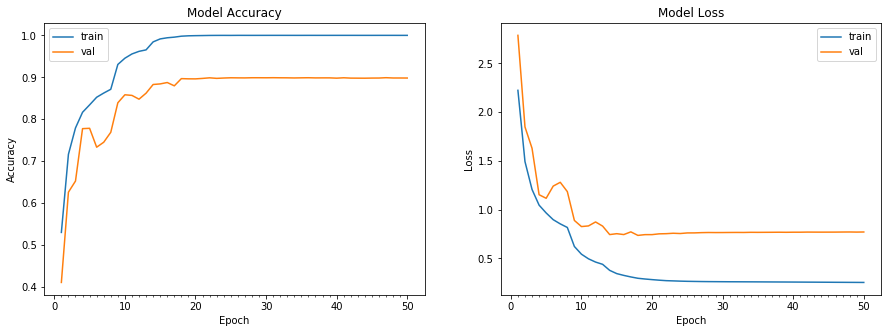

In [0]:
plot_model_history(model_info)

# **Save Model to drive**

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! cp /content/saved_models/cifar10_ResNet18v1_model.h5  /content/gdrive/My\ Drive/EIP4/Assignment4

cp: cannot stat '/content/saved_models/cifar10_ResNet18v1_model.h5': No such file or directory


## Load Model

In [12]:
!mkdir saved_models
!cp /content/gdrive/My\ Drive/EIP4/Assignment4/cifar10_ResNet18v1_model.h5 saved_models
filepath = 'saved_models/cifar10_ResNet18v1_model.h5'

mkdir: cannot create directory ‘saved_models’: File exists


#**Grad CAM**

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

from skimage import io

In [0]:
model.load_weights('/content/saved_models/cifar10_ResNet18v1_model.h5')

In [0]:
def get_gradCAM_heatmap(model, input_image, layer="activation_17"):
  input_shape = model.get_layer(index=0).input[0].shape[:2]
  
  orig_image = input_image
  input_image = cv2.resize(input_image, dsize=tuple(input_shape), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(input_image)
  x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)
  x = x.astype('float32')/255

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print('Predicted Class = {}'.format(class_idx))
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  # print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  # print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(grads.shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  # print(conv_layer_output_value.shape)
  print('Heatmap Shape = {}'.format(heatmap.shape))
  heatmap = np.maximum(heatmap, 0)
  # print(heatmap)
  heatmap /= np.max(heatmap)

  out_shape = 400
  heatmap = cv2.resize(heatmap, (out_shape, out_shape))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  orig_image = cv2.resize(orig_image, (out_shape, out_shape))
  superimposed_img = cv2.addWeighted(orig_image, 0.5, heatmap, 0.5, 0)

  cv2_imshow(orig_image)
  cv2_imshow(superimposed_img)

(32, 32)
Predicted Class = 5
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[1.8823339e-06 2.7041156e-06 1.1741017e-06 0.0000000e+00]
 [3.3926885e-06 5.0391072e-06 2.0191474e-06 0.0000000e+00]
 [2.7048959e-06 3.5163398e-06 1.3327716e-06 2.0135829e-07]
 [1.3918941e-06 1.6131428e-06 8.7795343e-07 7.8904770e-07]]


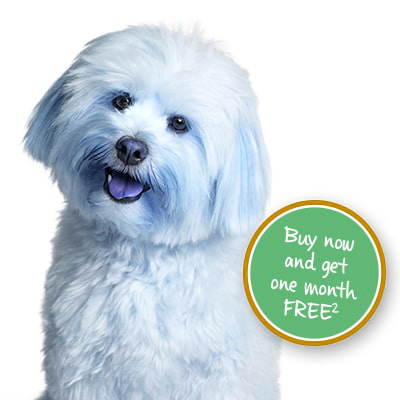

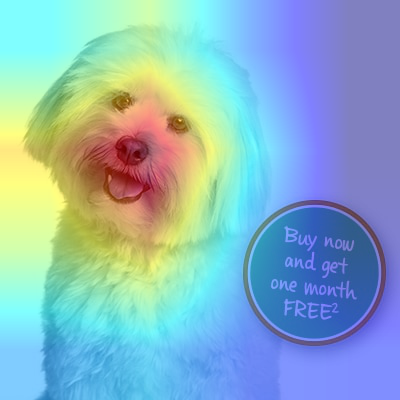

In [37]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
get_gradCAM_heatmap(model, dog, layer="activation_17")

(32, 32)
Predicted Class = 0
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.0775936e-13 4.0044576e-13 4.4254945e-13 0.0000000e+00]
 [1.5112866e-13 1.0850333e-12 6.9556660e-13 0.0000000e+00]
 [1.4796908e-12 2.2859657e-12 3.3264882e-12 2.6503407e-12]]


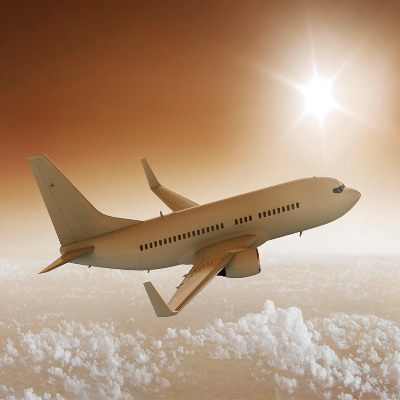

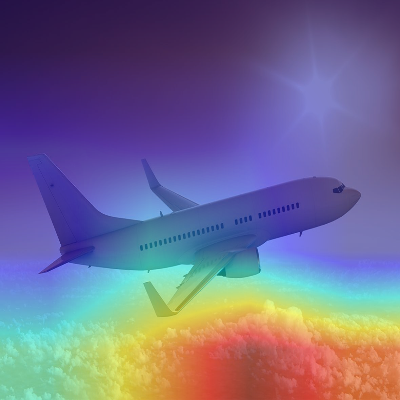

In [58]:
source = io.imread('https://freespira.com/wp-content/uploads/2019/10/air.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 2
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[4.2261794e-10 8.8823682e-10 1.2342474e-09 5.3177429e-10]
 [6.9242079e-10 1.4044990e-09 1.7086137e-09 1.0869263e-09]
 [6.7861206e-10 1.3715470e-09 1.4918294e-09 8.0556328e-10]
 [5.2484250e-10 9.2572683e-10 9.2828695e-10 4.1670636e-10]]


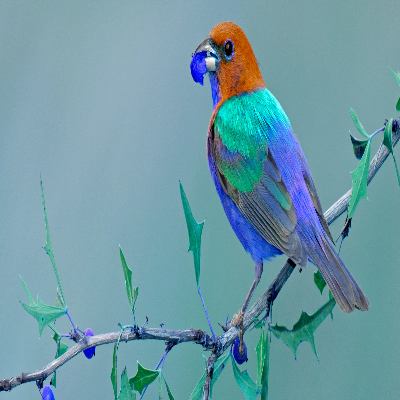

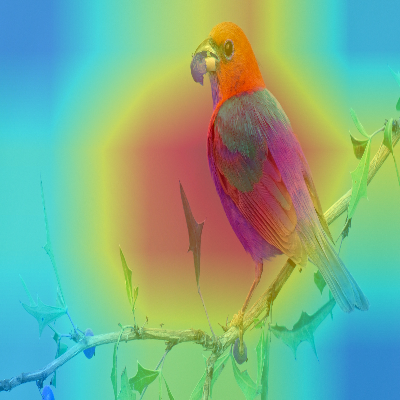

In [59]:
source = io.imread('https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 3
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[1.9717431e-06 4.5515981e-06 4.2185043e-06 6.7943720e-06]
 [1.3468864e-06 5.0314065e-06 5.7539419e-06 9.4861971e-06]
 [0.0000000e+00 2.8209129e-06 1.1296421e-05 1.3135276e-05]
 [0.0000000e+00 0.0000000e+00 8.2707193e-06 8.4941430e-06]]


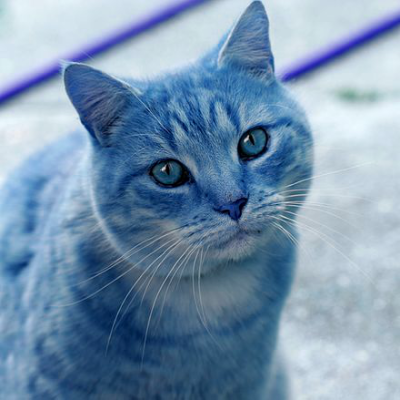

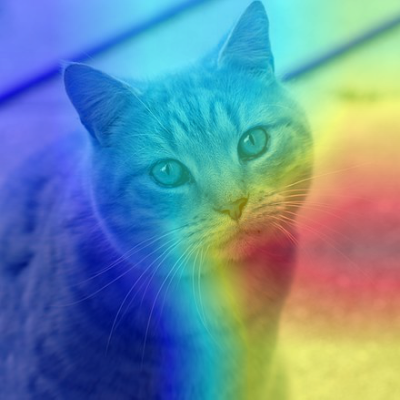

In [47]:
source = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/440px-Cat03.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 5
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[6.7108056e-05 1.2618187e-04 4.8189147e-05 3.2008138e-05]
 [2.0455487e-05 8.6509419e-05 4.5861882e-05 1.7664895e-05]
 [0.0000000e+00 9.3137845e-05 8.4912077e-05 9.9348681e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


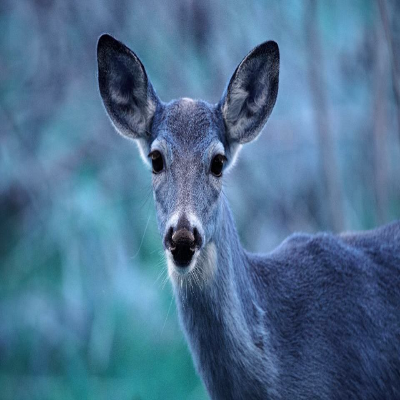

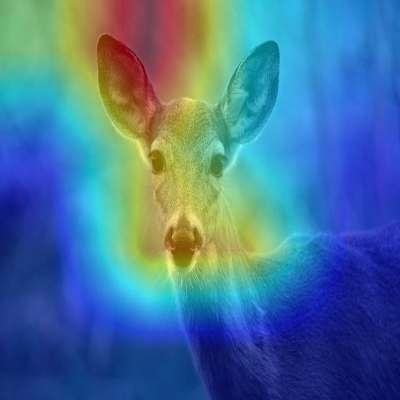

In [50]:
source = io.imread('https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1007655361%2F960x0.jpg%3Ffit%3Dscale')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 6
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[7.46844453e-09 8.15490679e-08 6.75093972e-08 2.95963218e-08]
 [1.18391696e-07 2.72044275e-07 3.55953318e-07 1.68401286e-07]
 [1.21051372e-07 2.42828378e-07 3.52875077e-07 1.68791686e-07]
 [1.13157554e-07 2.51297195e-07 3.27941166e-07 1.90682016e-07]]


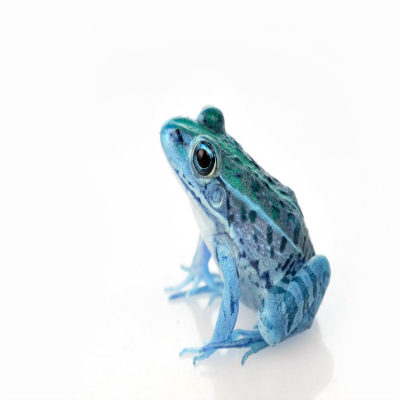

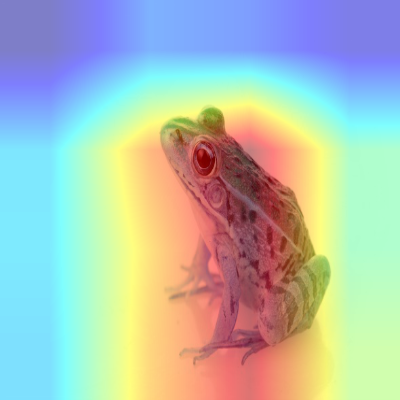

In [53]:
source = io.imread('https://www.petmd.com/sites/default/files/frog-care-101.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 7
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[1.1686070e-11 1.5120202e-11 1.4771784e-11 1.3721368e-11]
 [8.8400363e-12 4.5663221e-12 1.6260512e-11 6.2033859e-12]
 [1.1045098e-11 1.3285281e-11 1.8531895e-11 1.3344000e-11]
 [1.4035918e-11 5.0317615e-12 4.6820039e-12 4.1658118e-12]]


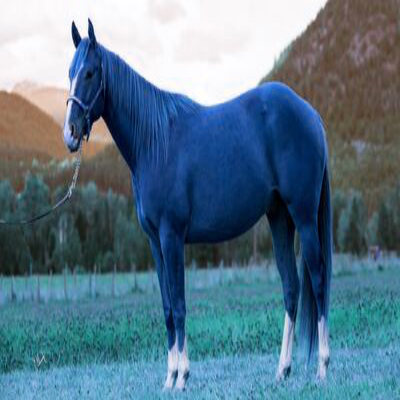

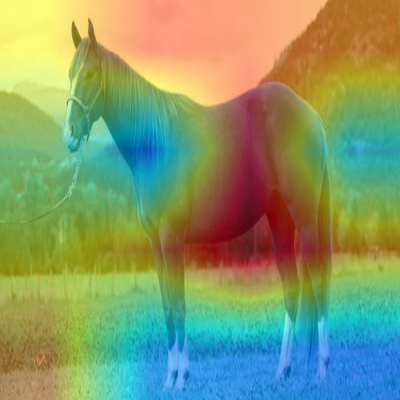

In [54]:
source = io.imread('https://vignette.wikia.nocookie.net/vsbattles/images/f/fa/Quarter_Horse.jpg/revision/latest/scale-to-width-down/400?cb=20190501064144')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 8
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[1.1721921e-09 1.9464119e-09 1.9877961e-09 9.5107189e-10]
 [2.0192734e-09 3.2508432e-09 3.9824082e-09 2.5829592e-09]
 [1.8775816e-09 3.3682961e-09 4.7727458e-09 3.6042065e-09]
 [9.8689135e-10 2.0474387e-09 2.8559677e-09 2.7570257e-09]]


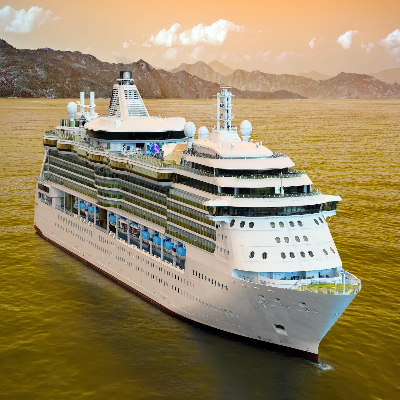

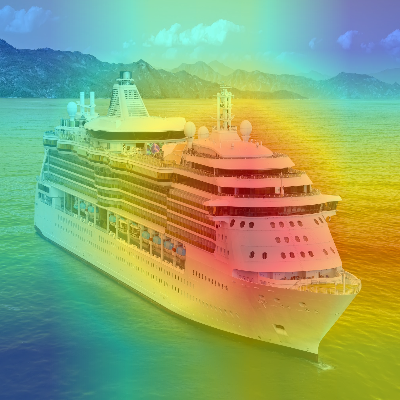

In [55]:
source = io.imread('https://static-ssl.businessinsider.com/image/5cbf50dfd1a2f8074406a8b2-2018/shutterstock439368427.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[0.0000000e+00 3.4543071e-08 2.3795789e-07 2.5960375e-07]
 [0.0000000e+00 1.4821805e-07 3.9219475e-07 3.8279052e-07]
 [0.0000000e+00 1.7506676e-07 3.7923007e-07 4.7316956e-07]
 [4.8030895e-08 9.7278246e-08 1.1930990e-07 1.0925304e-07]]


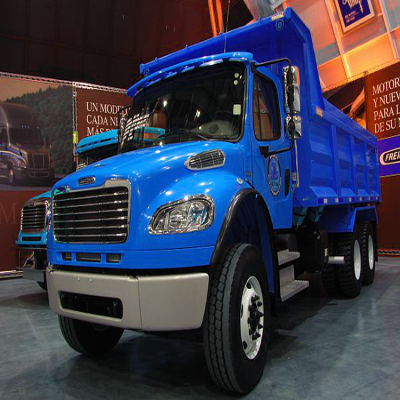

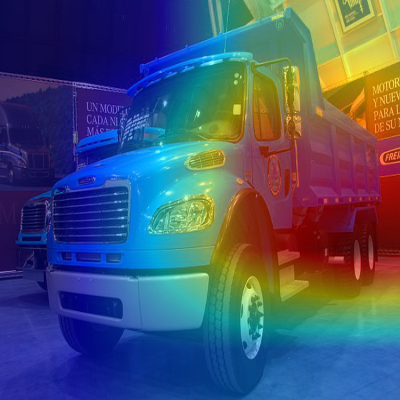

In [56]:
source = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Freightliner_M2_106_6x4_2014_%2814240376744%29.jpg/600px-Freightliner_M2_106_6x4_2014_%2814240376744%29.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[2.6689573e-10 1.6467834e-09 2.4759914e-09 2.0532211e-09]
 [2.7380009e-09 5.8348997e-09 6.1387584e-09 4.7050781e-09]
 [3.6246153e-09 7.2090418e-09 1.0038903e-08 8.1122566e-09]
 [2.8110143e-09 4.5427329e-09 4.8074451e-09 3.6745398e-09]]


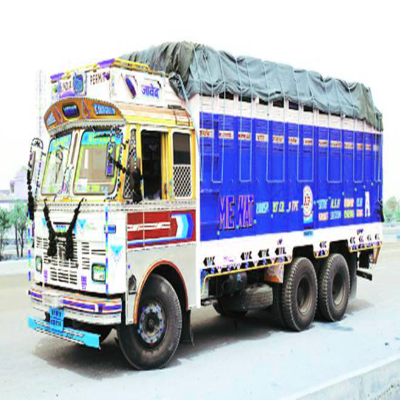

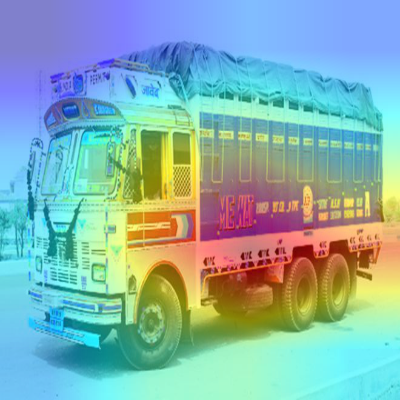

In [57]:
source = io.imread('https://images.financialexpress.com/2019/09/truck-660.jpg?w=660&h=440&imflag=true')
get_gradCAM_heatmap(model, source, layer="activation_17")

(32, 32)
Predicted Class = 0
(?, 4, 4, 512)
(512,)
(4, 4, 512)
Heatmap Shape = (4, 4)
[[1.9224964e-09 2.9448421e-09 3.0074583e-09 1.8815274e-09]
 [2.7405744e-09 4.2799058e-09 4.3446207e-09 2.4481885e-09]
 [2.3783500e-09 4.0851607e-09 4.5053143e-09 2.6064058e-09]
 [5.9825872e-10 1.4155975e-09 1.6924080e-09 1.0437693e-09]]


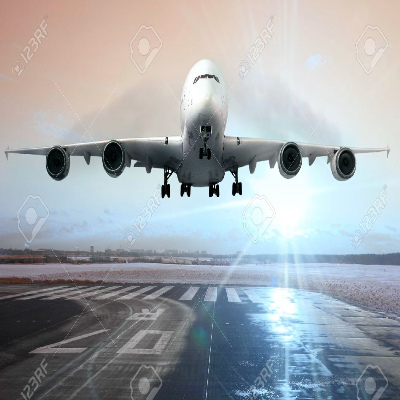

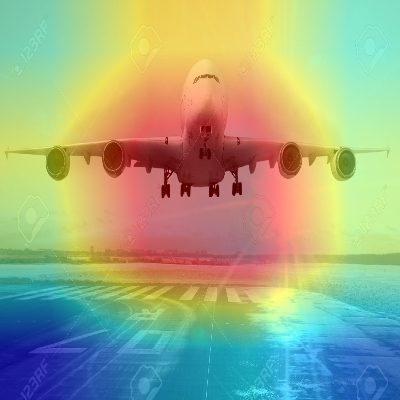

In [60]:
source = io.imread('https://previews.123rf.com/images/ivantagan/ivantagan1204/ivantagan120400051/13201718-passenger-airplane-landing-on-runway-in-airport-evening.jpg')
get_gradCAM_heatmap(model, source, layer="activation_17")